In [1]:
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
import mymodels
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

from keras.callbacks import TensorBoard
from keras.optimizers import SGD
from keras.optimizers import Adam
from collections import Counter
from utils.conf_matrix import plot_confusion_matrix as cm
import operator
import matplotlib.pyplot as plt
import numpy as np
import datetime
import argparse
import time 
import os
import tensorflow as tf
from keras.backend import tensorflow_backend

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True),
                        allow_soft_placement=True) #device_count={'GPU':2}
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
column = 'Classification'
num_images = 604
steps = 4
BS = int(num_images / steps ) 
IMAGE_DIMS = (128, 128, 3)
BASE_PATH_IMG = 'cell_image/aug_images2'
TRAIN_DIR = os.path.sep.join([BASE_PATH_IMG,column,'train'])
VAL_DIR = os.path.sep.join([BASE_PATH_IMG,column,'validation'])
val_datagen=ImageDataGenerator(rescale=1./255.)

valid_generator=val_datagen.flow_from_directory(
directory=VAL_DIR,
batch_size=BS,
shuffle=False,  #Very important or predict generator would not coincice with conf matrix
class_mode="categorical",
target_size=(IMAGE_DIMS[0],IMAGE_DIMS[1]))
MODEL =  mymodels.others.Cells5

Found 528 images belonging to 8 classes.


In [3]:
def init_model(model_file):
    print("[INFO] compiling model...")
    counter = Counter(valid_generator.classes)                          

    finalAct = 'softmax'
    #weights = 'pretrained_models/cells5_adam_noaug.h5'
    model = MODEL.build(
        width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
        depth=IMAGE_DIMS[2], classes=len(counter),
        finalAct=finalAct)


    filepath = os.path.sep.join(['checkpoints',model_file])
    model.load_weights(filepath)

    INIT_LR = 1e-4   #((1e-3 - 1e-4) / 2) + 1e-3
    DECAY = 1e-6
    opt = Adam(lr=INIT_LR, beta_1=0.9, beta_2=0.999, decay=DECAY, amsgrad=False)
    # compile the model
    model.compile(opt,loss="categorical_crossentropy",metrics=["accuracy"])
    
    return model


In [4]:
def get_conf_matrix(model_file):
    model = init_model(model_file)
    print('[INFO] predicting generator')
    Y_pred = model.predict_generator(valid_generator,steps=steps)
    y_pred = np.argmax(Y_pred, axis=1)
    sorted_x = sorted(valid_generator.class_indices.iteritems(), key=operator.itemgetter(1))
    class_labels = []
    for (label,key) in sorted_x:
        class_labels.append(label) 
    c = confusion_matrix(valid_generator.classes, y_pred)
    plt.figure()
    cm(c, classes=class_labels,title='Confusion matrix')
    plt.show()
    print('[INFO] evaluating generator')
    score = model.evaluate_generator(valid_generator,steps=steps)
    print('Accuracy : ' + str(score[1]) + 'Loss : ' + str(score[0]))
    del model

Here we need to clean gpu memory

In [6]:
tensorflow_backend.clear_session() # This doen's work nvidia-smi

[INFO] compiling model...
[INFO] predicting generator


/usr/lib64/python2.7/site-packages/scipy/sparse/coo.py:198: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:


Confusion matrix, without normalization
[[ 21   4   0   3   0   2   1   0]
 [  5  83  20   1  13  10   8  41]
 [  1   4  36   0   3   0   1   2]
 [  1   0   0  57   0   0   1   0]
 [  1   9   5   0   2   8   1   3]
 [  0   1   0   0   0  43   2   0]
 [  0   2   0   0   0   4   0   2]
 [  1  24   4   0   7   8   2 157]]


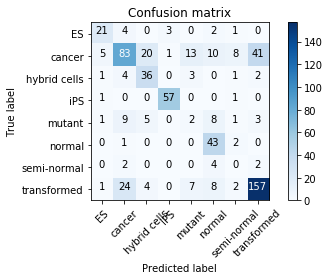

[INFO] evaluating generator
Accuracy : 0.660596027970314Loss : 1.0850230604410172


In [5]:
model_file = 'VGG19_15-0.67.hdf5'
MODEL =  mymodels.VGG19_frozen.VGG19
get_conf_matrix(model_file)

[INFO] compiling model...
[INFO] predicting generator


/usr/lib64/python2.7/site-packages/scipy/sparse/coo.py:198: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:


Confusion matrix, without normalization
[[ 16   9   0   2   0   2   2   0]
 [  0 121  18   1  15   8   5  13]
 [  0   9  30   0   7   0   0   1]
 [  1   2   0  56   0   0   0   0]
 [  0  11   3   0   5   8   2   0]
 [  0   2   0   0   0  44   0   0]
 [  0   3   0   0   1   3   0   1]
 [  0  39   2   0  12  10   1 139]]


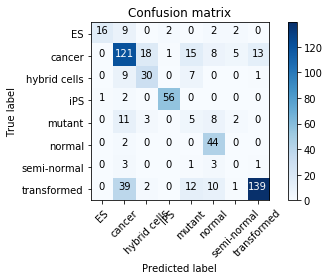

[INFO] evaluating generator
Accuracy : 0.6804635673761368Loss : 1.0887797325849533


In [7]:
model_file = 'VGG19softmax_17-0.70.hdf5'
MODEL =  mymodels.VGG19_frozen.VGG19
get_conf_matrix(model_file)

[INFO] compiling model...
[INFO] predicting generator


/usr/lib64/python2.7/site-packages/scipy/sparse/coo.py:198: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:


Confusion matrix, without normalization
[[ 23   3   0   3   0   2   0   0]
 [  2 106  20   0  14  13   2  24]
 [  0  10  33   0   1   0   0   3]
 [  1   0   0  58   0   0   0   0]
 [  0  10   3   0   3  11   1   1]
 [  0   1   0   0   1  41   3   0]
 [  0   5   0   0   0   3   0   0]
 [  1  34   2   1   7   9   3 146]]


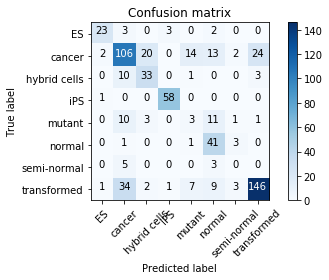

[INFO] evaluating generator
Accuracy : 0.678807944059372Loss : 1.6252780854701996


In [5]:
model_file = 'VGG19class_weights_57-0.67.hdf5'
MODEL =  mymodels.VGG19_frozen.VGG19
get_conf_matrix(model_file)

[INFO] compiling model...
[INFO] predicting generator
Confusion matrix, without normalization
[[ 18   3   0   1   0   0   0   1]
 [  9 104  20   1   9  10   3  10]
 [  0   5  23   0   1   0   0   1]
 [  3   1   0  42   0   0   0   0]
 [  1   7   6   1   5   7   1   2]
 [  0   4   0   0   0  35   0   0]
 [  0   3   0   0   0   1   0   0]
 [  0  31   6   0   6   7   0 140]]


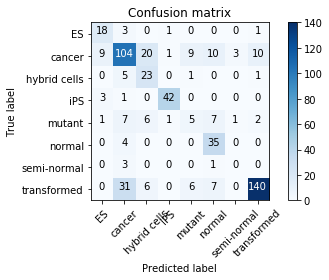

[INFO] evaluating generator
Accuracy : 0.695075751762047Loss : 1.2448203493699883


In [8]:
model_file = 'VGG19_23-0.69.hdf5'
MODEL =  mymodels.VGG19_frozen.VGG19
get_conf_matrix(model_file)

[INFO] compiling model...
[INFO] predicting generator
Confusion matrix, without normalization
[[ 15   4   0   3   0   0   0   1]
 [  2 113   7   1  17   7   2  17]
 [  0   4  19   0   6   0   0   1]
 [  1   1   0  44   0   0   0   0]
 [  1   9   4   0   7   4   2   3]
 [  0   4   0   0   1  32   1   1]
 [  0   3   0   0   1   0   0   0]
 [  1  27   0   0   9   6   0 147]]


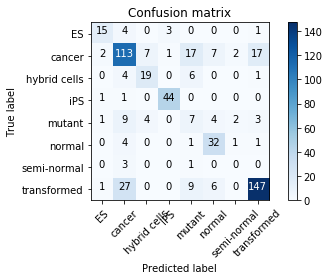

[INFO] evaluating generator
Accuracy : 0.7140151428228075Loss : 1.4459013287542444


In [5]:
model_file = 'VGG19_29-0.73_aug2.hdf5'
MODEL =  mymodels.VGG19_frozen.VGG19
get_conf_matrix(model_file)